# Backtesting Engine

## Data Collection

In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [345]:
data = pd.read_csv('VOL.IDXUSD_Ticks_24.03.2025-24.03.2025.csv')

In [346]:
data.head(15)

,Local time,Ask,Bid,AskVolume,BidVolume
0,24.03.2025 02:36:17.100 GMT-0400,18.93,18.72,0.006,0.006
1,24.03.2025 02:50:37.960 GMT-0400,18.87,18.68,0.006,0.006
2,24.03.2025 04:03:12.391 GMT-0400,18.83,18.62,0.006,0.006
3,24.03.2025 04:05:08.121 GMT-0400,18.78,18.57,0.006,0.006
4,24.03.2025 04:05:08.272 GMT-0400,18.82,18.63,0.006,0.006
5,24.03.2025 04:18:07.512 GMT-0400,18.88,18.67,0.006,0.006
6,24.03.2025 04:22:25.461 GMT-0400,18.83,18.62,0.006,0.006
7,24.03.2025 04:26:06.668 GMT-0400,18.88,18.67,0.006,0.006
8,24.03.2025 04:36:25.712 GMT-0400,18.83,18.62,0.006,0.006
9,24.03.2025 04:37:20.419 GMT-0400,18.87,18.68,0.006,0.006


In [347]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Local time  298 non-null    object 
 1   Ask         298 non-null    float64
 2   Bid         298 non-null    float64
 3   AskVolume   298 non-null    float64
 4   BidVolume   298 non-null    float64
dtypes: float64(4), object(1)
memory usage: 11.8+ KB


### Cleaning

In [348]:
data = data.drop_duplicates()

data = data.dropna()

data["Local time"] = pd.to_datetime(data["Local time"]) #convert the local time to a proper timestamp format

data = data.dropna(subset=['Ask','Bid']) #drop rows with missing ask or bid

C:\Users\anura\AppData\Local\Temp\ipykernel_15344\2604741831.py:5: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S.%f GMT%z format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["Local time"] = pd.to_datetime(data["Local time"]) #convert the local time to a proper timestamp format


### Storing cleaned data

In [349]:
data.to_parquet('cleaned_data.parquet')

## Implementing Backtesting System

### Load Data Efficiently

In [350]:
data = pd.read_parquet('cleaned_data.parquet') #loading parquet file
data

,Local time,Ask,Bid,AskVolume,BidVolume
0,2025-03-24 02:36:17.100000-04:00,18.93,18.72,0.006,0.006
1,2025-03-24 02:50:37.960000-04:00,18.87,18.68,0.006,0.006
2,2025-03-24 04:03:12.391000-04:00,18.83,18.62,0.006,0.006
3,2025-03-24 04:05:08.121000-04:00,18.78,18.57,0.006,0.006
4,2025-03-24 04:05:08.272000-04:00,18.82,18.63,0.006,0.006
...,...,...,...,...,...
293,2025-03-24 21:37:24.216000-04:00,18.13,17.92,0.006,0.006
294,2025-03-24 22:00:00.881000-04:00,18.18,17.97,0.006,0.006
295,2025-03-24 22:47:42.802000-04:00,18.23,17.97,0.006,0.006
296,2025-03-24 22:48:05.617000-04:00,18.18,17.97,0.006,0.006


In [351]:
data = data.set_index('Local time') #setting local time as index for fast queries
data.sort_index(inplace=True) #sorting just in case

data

,Ask,Bid,AskVolume,BidVolume
Local time,,,,
2025-03-24 02:36:17.100000-04:00,18.93,18.72,0.006,0.006
2025-03-24 02:50:37.960000-04:00,18.87,18.68,0.006,0.006
2025-03-24 04:03:12.391000-04:00,18.83,18.62,0.006,0.006
2025-03-24 04:05:08.121000-04:00,18.78,18.57,0.006,0.006
2025-03-24 04:05:08.272000-04:00,18.82,18.63,0.006,0.006
...,...,...,...,...
2025-03-24 21:37:24.216000-04:00,18.13,17.92,0.006,0.006
2025-03-24 22:00:00.881000-04:00,18.18,17.97,0.006,0.006
2025-03-24 22:47:42.802000-04:00,18.23,17.97,0.006,0.006


### Implement Basic Strategy

In [352]:
#parameters
rollingWindow = 10
initial_capital = 10000

#portfolio initialisation
cash = initial_capital
position = 0 #how many units currently own(0)
position_price = 0 #price at which last position was bought
trade_log = [] #record of each buy/sell trade
portfolio_log = []

In [353]:
#rolling parameters
data['Mean'] = (data['Ask'] + data['Bid'])/2
    #Bid Price = The highest price someone is willing to pay to buy an asset
    #Ask Price = The lowest price someone is willing to sell the asset for

data['Rolling Avg'] = data['Mean'].rolling(window=rollingWindow).mean()

data['Rolling STD'] = data['Mean'].rolling(window=rollingWindow).std()
data['Upper Band'] = data['Rolling Avg'] + 2 * data['Rolling STD']
data['Lower Band'] = data['Rolling Avg'] - 2 * data['Rolling STD']

data.head(25)

,Ask,Bid,AskVolume,BidVolume,Mean,Rolling Avg,Rolling STD,Upper Band,Lower Band
Local time,,,,,,,,,
2025-03-24 02:36:17.100000-04:00,18.93,18.72,0.006,0.006,18.825,NaN,NaN,NaN,NaN
2025-03-24 02:50:37.960000-04:00,18.87,18.68,0.006,0.006,18.775,NaN,NaN,NaN,NaN
2025-03-24 04:03:12.391000-04:00,18.83,18.62,0.006,0.006,18.725,NaN,NaN,NaN,NaN
2025-03-24 04:05:08.121000-04:00,18.78,18.57,0.006,0.006,18.675,NaN,NaN,NaN,NaN
2025-03-24 04:05:08.272000-04:00,18.82,18.63,0.006,0.006,18.725,NaN,NaN,NaN,NaN
2025-03-24 04:18:07.512000-04:00,18.88,18.67,0.006,0.006,18.775,NaN,NaN,NaN,NaN
2025-03-24 04:22:25.461000-04:00,18.83,18.62,0.006,0.006,18.725,NaN,NaN,NaN,NaN
2025-03-24 04:26:06.668000-04:00,18.88,18.67,0.006,0.006,18.775,NaN,NaN,NaN,NaN
2025-03-24 04:36:25.712000-04:00,18.83,18.62,0.006,0.006,18.725,NaN,NaN,NaN,NaN


In [354]:
#strategy logic
for time, row in data.iterrows():
    current_price = row['Mean']
    rolling_avg = row['Rolling Avg']
    upper_band = row['Upper Band']
    lower_band = row['Lower Band']
    ask = row['Ask']
    bid = row['Bid']

    if np.isnan(rolling_avg):
        continue

    if position == 0 and current_price < lower_band: 
        position = cash / ask
        position_price = ask
        cash = 0
        trade_log.append({'Type':'BUY', 'Time':time, 'Price':ask})
        #compare the current price, not the rolling average, against the bands because rolling average is the center line.

    elif position > 0 and current_price > upper_band:
        cash = position * bid
        position = 0
        position_price = 0
        trade_log.append({'Type':'SELL', 'Time':time, 'Price':bid})

    ##log portfolio value at every time step
    current_portfolio_value = cash if position == 0 else position * bid
    portfolio_log.append({'Time':time, 'Portfolio':current_portfolio_value})

#final portfolio value
final_value = cash if position == 0 else position * data.iloc[-1]['Bid'] 
    #if not holding anything, then final value = your cash
    #if still holding, we sell at the last known bid price

    #iloc: access rows and columns in a DataFrame by their numerical position, not their labels. "data.iloc[row_index, column_index]"
total_return_percent = (final_value-initial_capital)/initial_capital * 100

trade = pd.DataFrame(trade_log)
portfolio_df = pd.DataFrame(portfolio_log)

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return_percent:.2f}%")

Final Portfolio Value: $9470.91
Total Return: -5.29%


## Visualization

### Plot Mean Price and Bollinger  Bands with Buy/Sell Marker

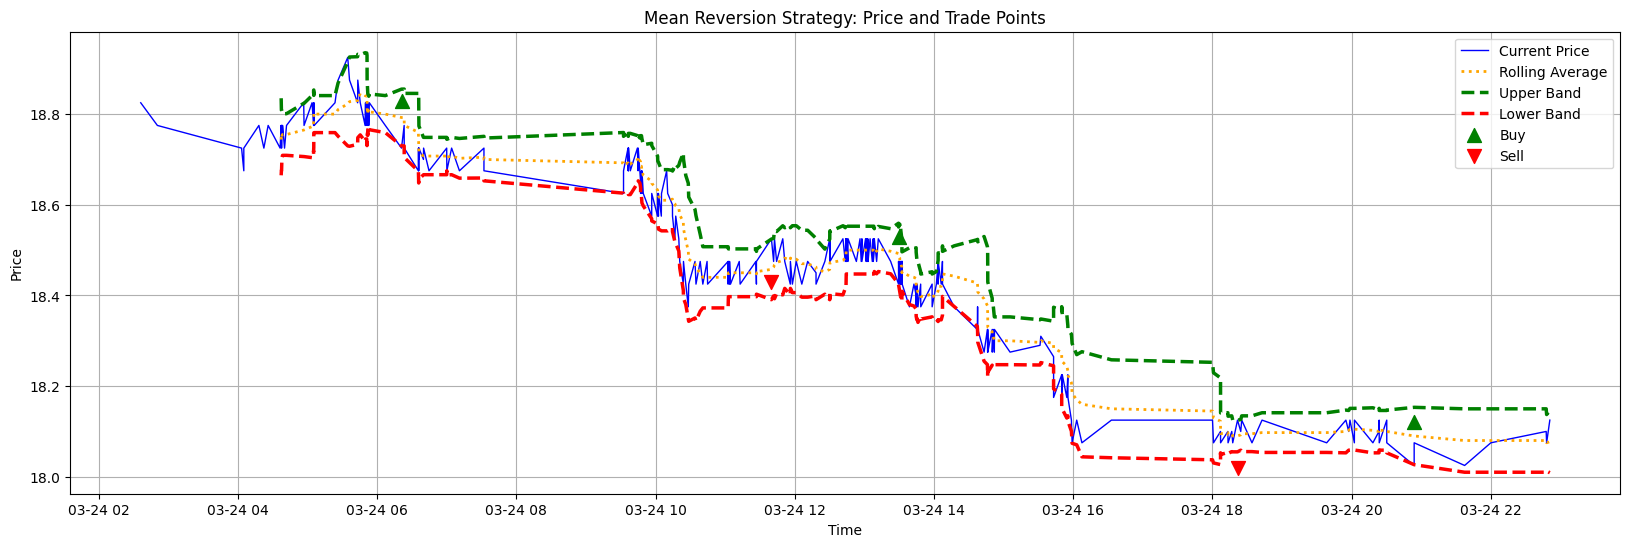

In [355]:
plt.figure(figsize=(20,6))
plt.plot(data.index, data['Mean'], label='Current Price', color='blue', linewidth=1)
plt.plot(data.index, data['Rolling Avg'], label='Rolling Average', color='orange', linestyle=':', linewidth=2)
plt.plot(data.index, data['Upper Band'], label='Upper Band', color='green', linestyle='--', linewidth=2.5)
plt.plot(data.index, data['Lower Band'], label='Lower Band', color='red', linestyle='--', linewidth=2.5)

#trade markers
buy_signals = [t for t in trade_log if t['Type'] == 'BUY']
sell_signals = [t for t in trade_log if t['Type'] == 'SELL']

plt.scatter([t['Time'] for t in buy_signals], [t['Price'] for t in buy_signals], marker='^', color='green', label='Buy', s=100)
plt.scatter([t['Time'] for t in sell_signals], [t['Price'] for t in sell_signals], marker='v', color='red', label='Sell', s=100)

plt.title('Mean Reversion Strategy: Price and Trade Points')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Plot Portfolio Value over Time

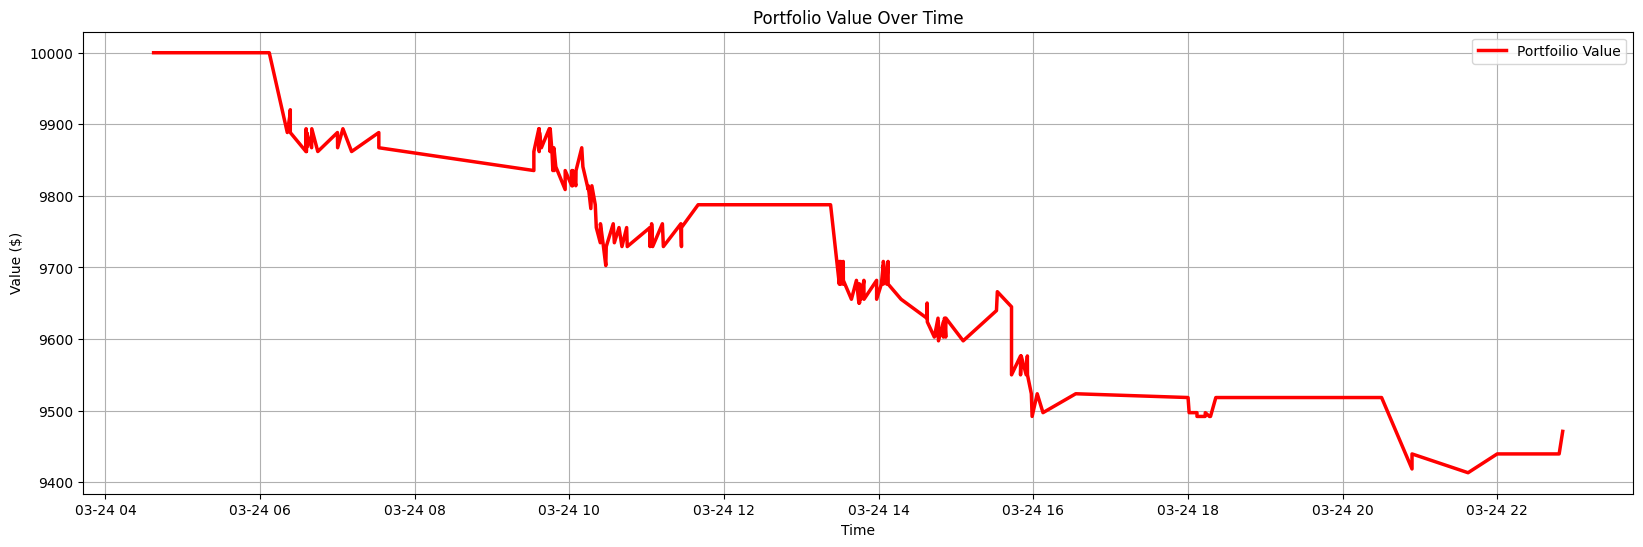

In [356]:
plt.figure(figsize=(20,6))
plt.plot(portfolio_df['Time'], portfolio_df['Portfolio'], '-r', label='Portfoilio Value', linewidth=2.5)
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value ($)')
plt.legend()
plt.grid()
plt.show()

## Strategy Expansion

### Relative Strength Index (RSI)

In [357]:
rsi_window = 14

def rsi(rsi_window):
    delta = data['Mean'].diff()
    #diff() - calculates how much the price changes compared to the previous value. ex:- [100,102,101] => [NaN,2,-1]
    gain = delta.clip(lower=0)
    #keep only the positive changes (gains) and set others to 0. ex:- gain:[NaN,2,0]
    loss = -delta.clip(upper=0)
    #keep only the negative changes (losses), but make them positive for math. ex:- loss:[NaN,0,1]

    avg_gain = gain.rolling(window=rsi_window).mean()
    avg_loss = loss.rolling(window=rsi_window).mean()

    rs = avg_gain/avg_loss

    rsi = 100 - (100/(1+rs))
    return rsi

data['RSI'] = rsi(rsi_window)

In [358]:
#strategy logic with RSI and SL/TP
stopLoss_percent = 0.01
takeProfit_percent = 0.02

for time, row in data.iterrows():
    current_price = row['Mean']
    upper_band = row['Upper Band']
    lower_band = row['Lower Band']
    rsi = row['RSI']
    rolling_avg = row['Rolling Avg']

    if np.isnan(rolling_avg) or np.isnan(rsi):
        continue

#entry conditions
    if position == 0:
        if current_price < lower_band and rsi < 30:
            position = cash / current_price
            position_price = current_price
            cash = 0
            trade_log.append({'Type':'BUY', 'Time':time, 'Price':current_price})

#exit conditions
    elif position > 0:
        #stop loss sell
        if current_price < position_price * (1 - stopLoss_percent):
            cash = position * current_price
            position = 0
            position_price = 0
            trade_log.append({'Type':'STOP-LOSS SELL', 'Time':time, 'Price':current_price})
        
        #take profit sell
        elif current_price > position_price * (1 + takeProfit_percent):
            cash = position * current_price
            position = 0
            position_price = 0
            trade_log.append({'Type':'TAKE-PROFIT SELL', 'Time':time, 'Price':current_price})

        #regular sell
        elif current_price > upper_band and rsi > 70:
            cash = position * current_price
            position = 0
            position_price = 0
            trade_log.append({'Type':'SELL', 'Time':time, 'Price': current_price})


    #log portfolio value at every time step
    current_portfolio_value = cash if position == 0 else position * current_price
    portfolio_log.append({'Time':time, 'Portfolio':current_portfolio_value})

#final portfolio value
final_value = cash if position == 0 else position * data.iloc[-1]['Mean'] 
total_return_percent = (final_value-initial_capital)/initial_capital * 100

trade = pd.DataFrame(trade_log)
portfolio_df = pd.DataFrame(portfolio_log)

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return_percent:.2f}%")

Final Portfolio Value: $9849.12
Total Return: -1.51%
